<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/add-lv-script/SBI-Diff-Simulator/notebooks/Compressor_for_lotka_volterra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet jax-cosmo numpyro dm-haiku==0.0.5 optax
!pip install --quiet git+https://github.com/Justinezgh/SBI-Diff-Simulator.git

     |████████████████████████████████| 283 kB 14.5 MB/s 
     |████████████████████████████████| 283 kB 70.8 MB/s 
     |████████████████████████████████| 287 kB 74.4 MB/s 
     |████████████████████████████████| 140 kB 53.7 MB/s 
     |████████████████████████████████| 72 kB 631 kB/s 
     |████████████████████████████████| 112 kB 15.0 MB/s 


In [2]:
import logging
# Removing annoying TFP error message
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

%pylab inline

import jax
import jax_cosmo as jc
import jax.numpy as jnp

import haiku as hk
import optax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sbids.metrics.c2st import c2st
from sbids.tasks import (
  lotka_volterra, lotka_volterra_y_bijector, 
  lotka_volterra_theta_bijector, get_samples_and_scores
)
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP

In [3]:
@jax.jit
def get_batch2(key, batch_size=1e5):
    model = lotka_volterra
    (log_probs, samples), scores = get_samples_and_scores(model, key, batch_size=batch_size)
    return samples['theta'], samples['y'].reshape([-1,20], order='F'), scores

In [4]:
class Compressor(hk.Module):

  def __call__(self, x):
    
    x = x/1000
    x = x[..., jnp.newaxis]

    net_x = hk.Conv1D(32, 3, 1)(x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Conv1D(64, 4, 2)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Conv1D(128, 3, 1)(net_x)
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Flatten()(net_x) 
    
    net_x = hk.Linear(32)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Linear(16)(net_x) 
    net_x = jax.nn.leaky_relu(net_x) 
    net_x = hk.Linear(4)(net_x) 

    return net_x.squeeze()

In [5]:
from functools import partial
bijector_layers = [128] * 2

bijector = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)

NF = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector)


class Flow_nd_Compressor2(hk.Module):
    def __call__(self, y):
        nvp = NF(4)(y)
        return tfd.TransformedDistribution(nvp,
                                           tfb.Chain([tfb.Invert(lotka_volterra_theta_bijector),
                                                      tfb.Scale(30.),
                                                      tfb.Shift(-0.5)]))

In [6]:
# compressor
compressor = hk.without_apply_rng(hk.transform(lambda x : Compressor()(x)))
rng_seq = hk.PRNGSequence(12)
params_c = compressor.init(next(rng_seq), 0.5*jnp.ones([1,20]))


# nf
nf = hk.without_apply_rng(hk.transform(lambda p,x : Flow_nd_Compressor2()(x).log_prob(p).squeeze()))
rng_seq = hk.PRNGSequence(2)
params_nf = nf.init(next(rng_seq),  0.5*jnp.ones([1,4]), 0.5*jnp.ones([1,4]))

parameters_compressor = hk.data_structures.merge(params_c, params_nf)

In [7]:
learning_rate=0.001
optimizer_c = optax.adam(learning_rate)
opt_state_c = optimizer_c.init(parameters_compressor)

In [8]:
def loss_compressor(params, mu, batch):
  y = compressor.apply(params, batch)
  log_prob = jax.vmap(lambda theta, x: nf.apply(params, theta.reshape([1,4]), x.reshape([1,4])).squeeze())(mu, y)
  return -jnp.mean(log_prob) 


@jax.jit
def update_compressor(params, opt_state, mu, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_compressor)(params, mu, batch)
    updates, new_opt_state = optimizer_c.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [9]:
from tqdm import tqdm
losses_c = []
master_seed = hk.PRNGSequence(0)

In [10]:
it = 2000

p, x, _ = get_batch2(jax.random.PRNGKey(12))

if jnp.isnan(x).any() == True:
  idx = jnp.where(jnp.isnan(x))[0]
  x = jnp.delete(x, idx, axis=0)
  p = jnp.delete(p, idx, axis=0)

for step in tqdm(range(it)):
  inds = np.random.randint(0, 100000, 256) 
  l, parameters_compressor, opt_state_c = update_compressor(parameters_compressor, opt_state_c, p[inds], x[inds])
  losses_c.append(l)

100%|██████████| 2000/2000 [01:03<00:00, 31.27it/s]


In [11]:
learning_rate=0.0001
optimizer_c = optax.adam(learning_rate)
opt_state_c = optimizer_c.init(parameters_compressor)

In [12]:
it = 38000
for step in tqdm(range(it)):
  inds = np.random.randint(0, 100000, 256) 
  l, parameters_compressor, opt_state_c = update_compressor(parameters_compressor, opt_state_c,  p[inds], x[inds])
  losses_c.append(l)

100%|██████████| 38000/38000 [11:10<00:00, 56.71it/s]


In [25]:
import pickle
with open("/content/params_compressor.pkl", "wb") as fp:
  pickle.dump(parameters_compressor, fp)

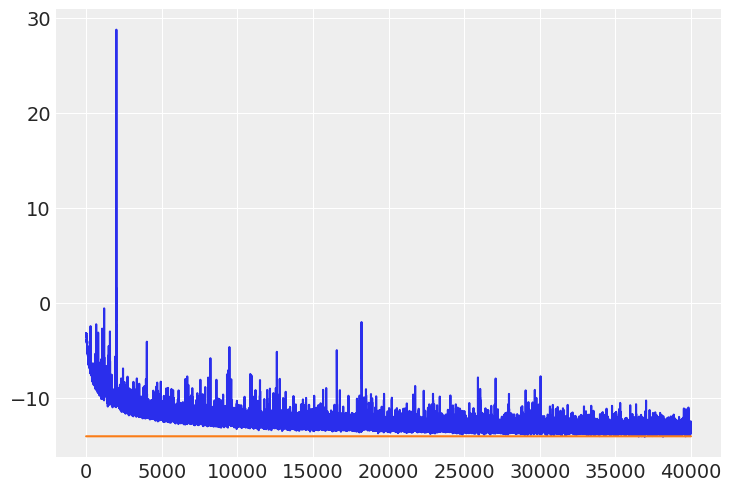

In [14]:
#silu
import arviz as az
az.style.use("arviz-darkgrid")

plot(losses_c)
plot(jnp.ones(len(losses_c))*(-14))

In [15]:
losses_c[-5]

DeviceArray(-13.415457, dtype=float32)

In [16]:
p, x, score = get_batch2(jax.random.PRNGKey(2))

if jnp.isnan(x).any() == True:
  idx = jnp.where(jnp.isnan(x))[0]
  x = jnp.delete(x, idx, axis=0)
  p = jnp.delete(p, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)
  
if jnp.isnan(score).any() == True:
  idx = jnp.where(jnp.isnan(score))[0]
  x = jnp.delete(x, idx, axis=0)
  p = jnp.delete(p, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

reg = compressor.apply(parameters_compressor,x)

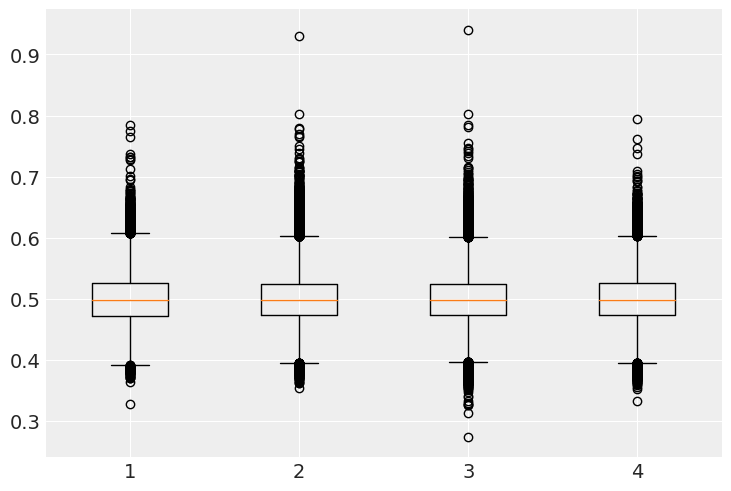

In [17]:
scale_reg = (jnp.std(reg, axis =0)/0.04)
shift_reg = jnp.mean(reg/scale_reg, axis = 0)-0.5

normalized_reg = (reg/scale_reg) - shift_reg
data = [normalized_reg[...,0],normalized_reg[...,1],normalized_reg[...,2],normalized_reg[...,3]]
plt.boxplot(data);

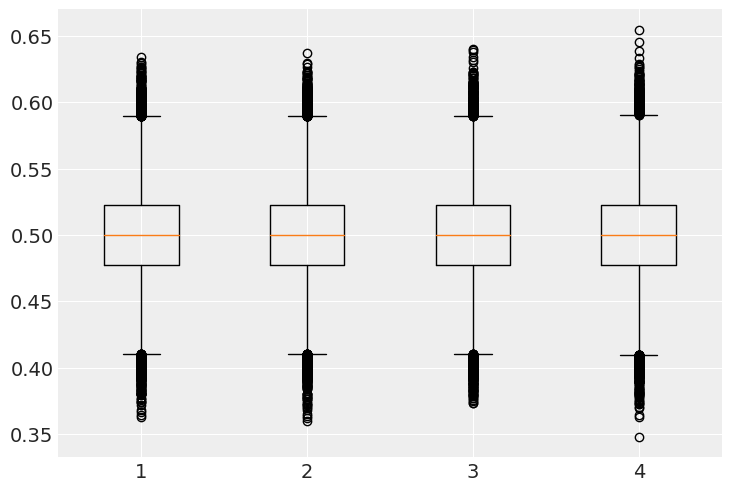

In [18]:
transfo = tfb.Chain([tfb.Invert(lotka_volterra_theta_bijector),tfb.Scale(30.),tfb.Shift(-0.5)])
newp = transfo.inverse(p)
data = [newp[...,0],newp[...,1],newp[...,2],newp[...,3]]
plt.boxplot(data);